#LAB 1: VGGNet & ResNet

<h4><div style="text-align: right"> Due date: 15:00 Oct 02, 2025.  </div> <br>
<div style="text-align: right"> Please upload your file and final-report at PLATO before the class in the form of [ID_Name_Lab1.ipynb]. </div></h4>

### *Instructions:*
- Write a program implementing a particular algorithm to solve a given problem.   
- <span style="color:red">**Report and discuss your results. Analyze the algorithm, theoretically and empirically.**</span>
- You must write their own answers and codes (<span style="color:red">**if not you will get a F grade**</span>).

<h2><span style="color:blue">[202355514] [강지원]</span> </h2>

In [1]:
import datetime
print("This code is written at " + str(datetime.datetime.now()))

This code is written at 2025-09-30 04:03:10.329527


In [3]:
#####################################################################
# In order to use GPU acceleration, you must change runtime type.
# See the menu bar above.
# "Runtime" -> "Change runtime type"  -> "Hardware accelerator"
# Change 'None' to 'GPU', then run the code below.
#####################################################################

import sys
import platform
import torch

print("Python version")
print(sys.version_info)

print("\nOS information")
print(platform.platform())

print("\nIs GPU available?")
print(torch.cuda.is_available())

# print("\nCPU information")
# !cat /proc/cpuinfo

# print("\nMemory information")
# !cat /proc/meminfo

print("\nGPU information")
!nvidia-smi

Python version
sys.version_info(major=3, minor=12, micro=11, releaselevel='final', serial=0)

OS information
Linux-6.6.97+-x86_64-with-glibc2.35

Is GPU available?
True

GPU information
Tue Sep 30 16:21:28 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   54C    P8             10W /   70W |   

## 1. VGGNet with PyTorch

### Implementing VGGNet

1. **Dataset**
 - Images from the first three categories in CIFAR-10. (Due to the computational constraints.)  <br>
     Three categories : plane, car, bird  /  The number of training images : 15,000   /  The number of test images : 3,000
 - Augmented with flipping and random cropping.

 2. **Network architecture**
 - Type-D configuration in the paper (+ 3-way classifier after convolutional layers).
 - ReLU activation.
 - No dropout for simplicity.
 - We will apply **batch-normalization** after every convolution which is not used in the paper (otherwise, hard to optimize).

 <table><tr>
 <td> <img src="https://docs.google.com/uc?export=download&id=1WoLTNYR11nbIE7ovpaum2DN_u71zow6r" alt="no_image" style="width: 550px;"/> </td>
 </tr></table>

 <font size="0.5"> Figure from <br>
 [1] https://www.quora.com/What-is-the-VGG-neural-network </font>

3. **Loss function**
 - Cross-entropy loss between outputs & ground-truths. <br>
     Note that `nn.CrossEntroyLoss` takes logits before softmax as network outputs and scalar index (not one-hot vector) as ground-truths.<br>
     See https://pytorch.org/docs/stable/nn.html#crossentropyloss for details.

 4. **Training**
 - Default weight initialization for simplicity.
 - SGD optimizer with `learning rate = 1e-2`, `momentum = 0.9`, and `weight_decay = 5e-4`.
 - 20 epochs without learning rate scheduling.

 5. **Evaluation metric**
 - Classification accuracy (i.e., the percentage of correct predictions).

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import torchvision
import time
import os

# os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [23]:
print('STEP 1: LOADING DATASET')

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_dataset = dsets.CIFAR10(root='./data/CIFAR10/',
                            train=True,
                            transform=transform_train,
                            download=True)

test_dataset = dsets.CIFAR10(root='./data/CIFAR10/',
                           train=False,
                           transform=transform_test)

STEP 1: LOADING DATASET


In [24]:
# reducing the dataset
reduced_train_dataset = []
for images, labels in train_dataset:
    if labels < 3:
        reduced_train_dataset.append((images, labels))

reduced_test_dataset = []
for images, labels in test_dataset:
    if labels < 3:
        reduced_test_dataset.append((images, labels))

In [6]:
print("The number of training images : ", len(reduced_train_dataset))
print("The number of test images : ", len(reduced_test_dataset))

The number of training images :  15000
The number of test images :  3000


In [25]:
print('STEP 2: MAKING DATASET ITERABLE')

train_loader = torch.utils.data.DataLoader(dataset=reduced_train_dataset,
                                           batch_size=128,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=reduced_test_dataset,
                                          batch_size=100,
                                          shuffle=False)

class_names = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

STEP 2: MAKING DATASET ITERABLE


### Visualize a few images

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [9]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.4914, 0.4822, 0.4465])
    std = np.array([0.2023, 0.1994, 0.2010])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

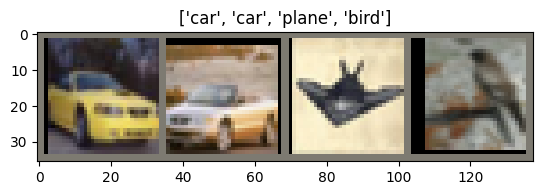

In [10]:
train_loader_sample = torch.utils.data.DataLoader(dataset=reduced_train_dataset,
                                           batch_size=4,
                                           shuffle=True)

# Get a batch of training data
inputs, classes = next(iter(train_loader_sample))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

### 1.1 Write code (VGG 16) [3 points]

In [49]:
print('STEP 3: CREATE MODEL CLASS (VGG16)')

#############
# CODE HERE #
#############

## BatchNorm2d(in_channel)

cfg = [64, 64, 'MP', 128, 128, 128, 'MP', 512, 512, 512, 'MP', 512, 512, 512, 'MP']

class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()
        self.VGG16 = self._make_layers(cfg)
        self.classifier = nn.Linear(512*2*2, 3)

    def forward(self, x):
        out = self.VGG16(x)
        # print("Shape before flattening:", out.shape)
        out = out.view(out.size(0), -1)
        # print("Shape after flattening:", out.shape)
        out = self.classifier(out)

        return out

    def _make_layers(self,cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'MP':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.ReLU(inplace=True),
                           nn.BatchNorm2d(x)]
                in_channels = x

        return nn.Sequential(*layers)

STEP 3: CREATE MODEL CLASS (VGG16)


In [50]:
print('STEP 4: INSTANTIATE MODEL CLASS')

model = VGG()
num_total_params = sum(p.numel() for p in model.parameters())
print("The number of parameters : ", num_total_params)
\

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

STEP 4: INSTANTIATE MODEL CLASS
The number of parameters :  12810435


VGG(
  (VGG16): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (1

In [51]:
print('STEP 5: INSTANTIATE LOSS CLASS')

criterion = nn.CrossEntropyLoss()

print('STEP 6: INSTANTIATE OPTIMIZER CLASS')

learning_rate = 1e-2
momentum = 0.9
weight_decay = 5e-4

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum = momentum, weight_decay = weight_decay)

STEP 5: INSTANTIATE LOSS CLASS
STEP 6: INSTANTIATE OPTIMIZER CLASS


### 1.2 Train the VGG 16 model and print test accuracy for every epochs [2 points]

In [52]:
print('STEP 7: TRAIN THE MODEL')
num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    start_time = time.time()

    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)

        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = (correct / total) * 100
    elapsed_time = time.time() - start_time

    print(f"Epochs: {epoch}. Loss: {epoch_loss}. Accuracy: {epoch_accuracy}. Elapsed time: {elapsed_time} sec")

STEP 7: TRAIN THE MODEL
Epochs: 0. Loss: 1.3608666693760176. Accuracy: 60.14666666666667. Elapsed time: 7.862557888031006 sec
Epochs: 1. Loss: 0.702910938505399. Accuracy: 73.94. Elapsed time: 8.066734790802002 sec
Epochs: 2. Loss: 0.6125931030107756. Accuracy: 77.45333333333333. Elapsed time: 8.278175830841064 sec
Epochs: 3. Loss: 0.44523664576522376. Accuracy: 82.46. Elapsed time: 8.186424016952515 sec
Epochs: 4. Loss: 0.4376034847760605. Accuracy: 83.62666666666667. Elapsed time: 7.9537036418914795 sec
Epochs: 5. Loss: 0.37528093967397336. Accuracy: 85.15333333333334. Elapsed time: 7.824023246765137 sec
Epochs: 6. Loss: 0.32727092365592214. Accuracy: 87.38. Elapsed time: 7.769190788269043 sec
Epochs: 7. Loss: 0.30299321246349203. Accuracy: 88.20666666666666. Elapsed time: 7.74968147277832 sec
Epochs: 8. Loss: 0.2507429179751267. Accuracy: 90.22. Elapsed time: 7.73651385307312 sec
Epochs: 9. Loss: 0.6231601821669077. Accuracy: 79.49333333333334. Elapsed time: 7.7528088092803955 sec
E

## 2. ResNet with PyTorch

### Implementing ResNet

 1. **Dataset**
 - The same dataset used for VGGNet

 2. **Network architecture**
 - 50-layer ResNet with **bottleneck blocks**. <br>
     Note. The initial convolution layer (i.e., conv1) is different from the one in the paper &<br>
     the initial max-pooling layer is removed (because the size of CIFAR-10 images is too small).
 - ReLU activation.
 - Strided convolution for down-sampling instead of max-pooling layer. <br>
     Note. Once down-sampled, a $1\times1$ convolution/stride 2 is applied to residual for expanding the channel of the residual.
 - No dropout for simplicity.
 - Batch-normalization after every convolution.


 <table><tr>
 <td> <img src="https://docs.google.com/uc?export=download&id=1UbSh2w83Tb0VVgXxyly_VAUPwE7UsdAE" alt="no_image" style="width: 500px;"/> </td>
 </tr></table>

 <font size="0.5"> Figures from <br>
 [1] https://www.codeproject.com/Articles/1248963/Deep-Learning-using-Python-plus-Keras-Chapter-Re  <br>
 [2] Rezende et al., *Signal Processing: Image Communication*, 2018. </font>

3. **Loss function**
- Cross-entropy loss between outputs & ground-truths. <br>

4. **Training**
 - Default weight initialization for simplicity.
 - SGD optimizer with `learning rate = 1e-2`, `momentum = 0.9`, and `weight_decay = 5e-4`.
- 15 epochs without learning rate scheduling.

5. **Evaluation metric**
 - Classification accuracy (i.e., the percentage of correct predictions).

### 2.1 Implement ResNet50 and train it with the CIFAR 10 dataset [4 points]

In [11]:
print('STEP 3: CREATE MODEL CLASS (ResNet-50)')

cfg = [3,4,6,3]

class ResNet_block(nn.Module):
    def __init__(self, in_c, intra_c, out_c, down_sample = False):
        super(ResNet_block, self).__init__()

        self.down_sample = down_sample
        self.expand = in_c != out_c

        stride = 2 if down_sample else 1

        self.conv1 = nn.Conv2d(in_c, intra_c, kernel_size=1, stride=1, bias=False)
        self.bn1 = nn.BatchNorm2d(intra_c)

        self.conv2 = nn.Conv2d(intra_c, intra_c, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(intra_c)

        self.conv3 = nn.Conv2d(intra_c, out_c, kernel_size=1, stride=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_c)

        if down_sample or self.expand:
            self.convert_id = nn.Sequential(
                nn.Conv2d(in_c, out_c, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_c)
            )
        else:
            self.convert_id = nn.Sequential()


    def forward(self, x):
        identity = x

        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))

        if self.down_sample or self.expand:
            identity = self.convert_id(x)

        out = F.relu(out + identity)
        return out

class ResNet(nn.Module):
    def __init__(self):
        super(ResNet, self).__init__()
        self.init_block = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )

        self.ResBlock1 = self._make_layers(64, 64, 256, cfg[0], down_sample=False)
        self.ResBlock2 = self._make_layers(256, 128, 512, cfg[1], down_sample=True)
        self.ResBlock3 = self._make_layers(512, 256, 1024, cfg[2], down_sample=True)
        self.ResBlock4 = self._make_layers(1024, 512, 2048, cfg[3], down_sample=True)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        self.classifier = nn.Linear(2048, 3)

    def forward(self, x):
        out = self.init_block(x)
        out = self.ResBlock1(out)
        out = self.ResBlock2(out)
        out = self.ResBlock3(out)
        out = self.ResBlock4(out)
        out = self.avgpool(out)
        out= out.view(out.size(0), -1)
        out = self.classifier(out)

        return out

    def _make_layers(self, in_c, intra_c, out_c, num_block, down_sample):
        layers = []
        layers.append(ResNet_block(in_c = in_c, intra_c = intra_c, out_c = out_c, down_sample = down_sample))

        for _ in range(num_block - 1):
            layers.append(ResNet_block(in_c = out_c, intra_c = intra_c, out_c = out_c, down_sample = False))

        return nn.Sequential(*layers)


print('STEP 4: INSTANTIATE MODEL CLASS')

model = ResNet()
model = model.to(device)

STEP 3: CREATE MODEL CLASS (ResNet-50)
STEP 4: INSTANTIATE MODEL CLASS


### 2.2 Print test accuracy for every epochs. [1 points]

In [102]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print('STEP 5: INSTANTIATE LOSS CLASS')
criterion = nn.CrossEntropyLoss()


print('STEP 6: INSTANTIATE OPTIMIZER CLASS')
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)


print('STEP 7: TRAIN THE MODEL')
num_epochs = 15

for epoch in range(num_epochs):
    start_time = time.time()

    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_accuracy = 100 * correct / total
    epoch_loss = running_loss / len(train_loader)
    elapsed_time = time.time() - start_time

    print(f"Epochs: {epoch}. Loss: {epoch_loss}. Accuracy: {epoch_accuracy}. Elapsed time: {elapsed_time} sec")


STEP 5: INSTANTIATE LOSS CLASS
STEP 6: INSTANTIATE OPTIMIZER CLASS
STEP 7: TRAIN THE MODEL
Epochs: 0. Loss: 1.2809745144035856. Accuracy: 54.4. Elapsed time: 48.57177734375 sec
Epochs: 1. Loss: 0.6931785802214833. Accuracy: 74.06. Elapsed time: 46.903950691223145 sec
Epochs: 2. Loss: 0.5213532271021504. Accuracy: 79.58. Elapsed time: 48.0087194442749 sec
Epochs: 3. Loss: 0.46245582603802116. Accuracy: 82.41333333333333. Elapsed time: 47.48534274101257 sec
Epochs: 4. Loss: 0.39024251989893993. Accuracy: 85.05333333333333. Elapsed time: 47.692107915878296 sec
Epochs: 5. Loss: 0.3818307460869773. Accuracy: 85.64666666666666. Elapsed time: 47.588213205337524 sec
Epochs: 6. Loss: 0.31684576290643823. Accuracy: 87.76. Elapsed time: 47.80878400802612 sec
Epochs: 7. Loss: 0.28739627690638525. Accuracy: 89.14666666666666. Elapsed time: 47.46664333343506 sec
Epochs: 8. Loss: 0.2468026712915655. Accuracy: 90.80666666666667. Elapsed time: 47.559022665023804 sec
Epochs: 9. Loss: 0.2018347204489223.

## Discussion 1-1. RandomCrop만 이용한 경우

In [8]:
print('STEP 1: LOADING DATASET (RandomCrop Only)')

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_dataset = dsets.CIFAR10(root='./data/CIFAR10/',
                            train=True,
                            transform=transform_train,
                            download=True)

test_dataset = dsets.CIFAR10(root='./data/CIFAR10/',
                           train=False,
                           transform=transform_test)


STEP 1: LOADING DATASET (RandomCrop Only)


In [9]:

reduced_train_dataset = []
for images, labels in train_dataset:
    if labels < 3:
        reduced_train_dataset.append((images, labels))

reduced_test_dataset = []
for images, labels in test_dataset:
    if labels < 3:
        reduced_test_dataset.append((images, labels))

print('STEP 2: MAKING DATASET ITERABLE (RandomCrop Only)')

train_loader = torch.utils.data.DataLoader(dataset=reduced_train_dataset,
                                           batch_size=128,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=reduced_test_dataset,
                                          batch_size=100,
                                          shuffle=False)

class_names = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

STEP 2: MAKING DATASET ITERABLE (RandomCrop Only)


In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print('STEP 5: INSTANTIATE LOSS CLASS(RandomCrop Only)')

criterion = nn.CrossEntropyLoss()


print('STEP 6: INSTANTIATE OPTIMIZER CLASS(RandomCrop Only)')

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)


print('STEP 7: TRAIN THE MODEL(RandomCrop Only)')
num_epochs = 15

for epoch in range(num_epochs):
    start_time = time.time()

    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_accuracy = 100 * correct / total
    epoch_loss = running_loss / len(train_loader)
    elapsed_time = time.time() - start_time

    print(f"Epochs: {epoch}. Loss: {epoch_loss}. Accuracy: {epoch_accuracy}. Elapsed time: {elapsed_time} sec")


STEP 5: INSTANTIATE LOSS CLASS(RandomCrop Only)
STEP 6: INSTANTIATE OPTIMIZER CLASS(RandomCrop Only)
STEP 7: TRAIN THE MODEL(RandomCrop Only)
Epochs: 0. Loss: 1.3323032845885068. Accuracy: 54.22. Elapsed time: 44.331655502319336 sec
Epochs: 1. Loss: 0.6366709316686049. Accuracy: 75.1. Elapsed time: 46.09127426147461 sec
Epochs: 2. Loss: 0.5548643570835308. Accuracy: 78.52. Elapsed time: 46.26763367652893 sec
Epochs: 3. Loss: 0.47394128907787597. Accuracy: 81.67333333333333. Elapsed time: 46.24515438079834 sec
Epochs: 4. Loss: 0.4130170171038579. Accuracy: 84.28666666666666. Elapsed time: 46.19389033317566 sec
Epochs: 5. Loss: 0.4013217783580392. Accuracy: 84.94666666666667. Elapsed time: 46.15779709815979 sec
Epochs: 6. Loss: 0.36866771846504537. Accuracy: 86.15333333333334. Elapsed time: 46.33334970474243 sec
Epochs: 7. Loss: 0.30746557361493676. Accuracy: 88.42. Elapsed time: 46.42986226081848 sec
Epochs: 8. Loss: 0.2553204204571449. Accuracy: 90.45333333333333. Elapsed time: 46.3916

## Discussion 1-2. RandomHorizontalFlip만 이용한 경우

In [13]:
print('STEP 1: LOADING DATASET (RandomHorizontalFlip Only)')

transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_dataset = dsets.CIFAR10(root='./data/CIFAR10/',
                            train=True,
                            transform=transform_train,
                            download=True)

test_dataset = dsets.CIFAR10(root='./data/CIFAR10/',
                           train=False,
                           transform=transform_test)


STEP 1: LOADING DATASET (RandomHorizontalFlip Only)


In [14]:
reduced_train_dataset = []
for images, labels in train_dataset:
    if labels < 3:
        reduced_train_dataset.append((images, labels))

reduced_test_dataset = []
for images, labels in test_dataset:
    if labels < 3:
        reduced_test_dataset.append((images, labels))

print('STEP 2: MAKING DATASET ITERABLE (RandomHorizontalFlip Only)')

train_loader = torch.utils.data.DataLoader(dataset=reduced_train_dataset,
                                           batch_size=128,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=reduced_test_dataset,
                                          batch_size=100,
                                          shuffle=False)

class_names = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

STEP 2: MAKING DATASET ITERABLE (RandomHorizontalFlip Only)


In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print('STEP 5: INSTANTIATE LOSS CLASS(RandomHorizontalFlip Only)')

criterion = nn.CrossEntropyLoss()


print('STEP 6: INSTANTIATE OPTIMIZER CLASS(RandomHorizontalFlip Only)')
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)


print('STEP 7: TRAIN THE MODEL(RandomHorizontalFlip Only)')
num_epochs = 15

for epoch in range(num_epochs):
    start_time = time.time()

    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_accuracy = 100 * correct / total
    epoch_loss = running_loss / len(train_loader)
    elapsed_time = time.time() - start_time

    print(f"Epochs: {epoch}. Loss: {epoch_loss}. Accuracy: {epoch_accuracy}. Elapsed time: {elapsed_time} sec")


STEP 5: INSTANTIATE LOSS CLASS(RandomHorizontalFlip Only)
STEP 6: INSTANTIATE OPTIMIZER CLASS(RandomHorizontalFlip Only)
STEP 7: TRAIN THE MODEL(RandomHorizontalFlip Only)
Epochs: 0. Loss: 0.25206999821683107. Accuracy: 90.62666666666667. Elapsed time: 47.70502424240112 sec
Epochs: 1. Loss: 0.14560889345356973. Accuracy: 94.66666666666667. Elapsed time: 45.79457712173462 sec
Epochs: 2. Loss: 0.09396634872813346. Accuracy: 96.47333333333333. Elapsed time: 46.65084385871887 sec
Epochs: 3. Loss: 0.07516197928116988. Accuracy: 97.32. Elapsed time: 46.13857960700989 sec
Epochs: 4. Loss: 0.07945164611910359. Accuracy: 97.12. Elapsed time: 46.38106346130371 sec
Epochs: 5. Loss: 0.05722977558813863. Accuracy: 97.98666666666666. Elapsed time: 46.34382939338684 sec
Epochs: 6. Loss: 0.03558006264285137. Accuracy: 98.65333333333334. Elapsed time: 46.23841452598572 sec
Epochs: 7. Loss: 0.03979982632228126. Accuracy: 98.65333333333334. Elapsed time: 46.21467423439026 sec
Epochs: 8. Loss: 0.038850367

## Discussion 1-3. ColorJitter + RandomHorizontalFlip 이용한 경우

밝기, 대비 및 채도 조정

In [16]:
print('STEP 1: LOADING DATASET (ColorJitter + RandomHorizontalFlip)')

transform_train = transforms.Compose([
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_dataset = dsets.CIFAR10(root='./data/CIFAR10/',
                            train=True,
                            transform=transform_train,
                            download=True)

test_dataset = dsets.CIFAR10(root='./data/CIFAR10/',
                           train=False,
                           transform=transform_test)


STEP 1: LOADING DATASET (ColorJitter + RandomHorizontalFlip)


In [17]:
reduced_train_dataset = []
for images, labels in train_dataset:
    if labels < 3:
        reduced_train_dataset.append((images, labels))

reduced_test_dataset = []
for images, labels in test_dataset:
    if labels < 3:
        reduced_test_dataset.append((images, labels))

print('STEP 2: MAKING DATASET ITERABLE(ColorJitter + RandomHorizontalFlip)')

train_loader = torch.utils.data.DataLoader(dataset=reduced_train_dataset,
                                           batch_size=128,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=reduced_test_dataset,
                                          batch_size=100,
                                          shuffle=False)

class_names = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

STEP 2: MAKING DATASET ITERABLE(ColorJitter + RandomHorizontalFlip)


In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print('STEP 5: INSTANTIATE LOSS CLASS(ColorJitter + RandomHorizontalFlip)')

criterion = nn.CrossEntropyLoss()


print('STEP 6: INSTANTIATE OPTIMIZER CLASS(ColorJitter + RandomHorizontalFlip)')
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)


print('STEP 7: TRAIN THE MODEL(ColorJitter + RandomHorizontalFlip)')
num_epochs = 15

for epoch in range(num_epochs):
    start_time = time.time()

    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_accuracy = 100 * correct / total
    epoch_loss = running_loss / len(train_loader)
    elapsed_time = time.time() - start_time

    print(f"Epochs: {epoch}. Loss: {epoch_loss}. Accuracy: {epoch_accuracy}. Elapsed time: {elapsed_time} sec")


STEP 5: INSTANTIATE LOSS CLASS(ColorJitter + RandomHorizontalFlip)
STEP 6: INSTANTIATE OPTIMIZER CLASS(ColorJitter + RandomHorizontalFlip)
STEP 7: TRAIN THE MODEL(ColorJitter + RandomHorizontalFlip)
Epochs: 0. Loss: 0.18021082136211758. Accuracy: 93.89333333333333. Elapsed time: 47.79988670349121 sec
Epochs: 1. Loss: 0.072833415357617. Accuracy: 97.45333333333333. Elapsed time: 45.73178720474243 sec
Epochs: 2. Loss: 0.03788480874924463. Accuracy: 98.64666666666666. Elapsed time: 46.71587777137756 sec
Epochs: 3. Loss: 0.02570799669503408. Accuracy: 99.22. Elapsed time: 46.16703200340271 sec
Epochs: 4. Loss: 0.030652093736581124. Accuracy: 98.88. Elapsed time: 46.403231620788574 sec
Epochs: 5. Loss: 0.018900780213929682. Accuracy: 99.32. Elapsed time: 46.4328191280365 sec
Epochs: 6. Loss: 0.028759648228237816. Accuracy: 99.06666666666666. Elapsed time: 46.32403755187988 sec
Epochs: 7. Loss: 0.018977154248544032. Accuracy: 99.46666666666667. Elapsed time: 46.23326110839844 sec
Epochs: 8. 

## Discussion 1-4. GaussianBlur + RandomHorizontalFlip 이용한 경우

In [19]:
print('STEP 1: LOADING DATASET (GaussianBlur + RandomHorizontalFlip)')

transform_train = transforms.Compose([
    transforms.GaussianBlur(kernel_size=5),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_dataset = dsets.CIFAR10(root='./data/CIFAR10/',
                            train=True,
                            transform=transform_train,
                            download=True)

test_dataset = dsets.CIFAR10(root='./data/CIFAR10/',
                           train=False,
                           transform=transform_test)


In [20]:
reduced_train_dataset = []
for images, labels in train_dataset:
    if labels < 3:
        reduced_train_dataset.append((images, labels))

reduced_test_dataset = []
for images, labels in test_dataset:
    if labels < 3:
        reduced_test_dataset.append((images, labels))

print('STEP 2: MAKING DATASET ITERABLE(GaussianBlur + RandomHorizontalFlip)')

train_loader = torch.utils.data.DataLoader(dataset=reduced_train_dataset,
                                           batch_size=128,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=reduced_test_dataset,
                                          batch_size=100,
                                          shuffle=False)

class_names = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

STEP 2: MAKING DATASET ITERABLE(GaussianBlur + RandomHorizontalFlip)


In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print('STEP 5: INSTANTIATE LOSS CLASS(GaussianBlur + RandomHorizontalFlip)')

criterion = nn.CrossEntropyLoss()


print('STEP 6: INSTANTIATE OPTIMIZER CLASS(GaussianBlur + RandomHorizontalFlip)')

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)


print('STEP 7: TRAIN THE MODEL(GaussianBlur + RandomHorizontalFlip)')

num_epochs = 15

for epoch in range(num_epochs):
    start_time = time.time()

    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_accuracy = 100 * correct / total
    epoch_loss = running_loss / len(train_loader)
    elapsed_time = time.time() - start_time

    print(f"Epochs: {epoch}. Loss: {epoch_loss}. Accuracy: {epoch_accuracy}. Elapsed time: {elapsed_time} sec")


STEP 5: INSTANTIATE LOSS CLASS(GaussianBlur + RandomHorizontalFlip)
STEP 6: INSTANTIATE OPTIMIZER CLASS(GaussianBlur + RandomHorizontalFlip)
STEP 7: TRAIN THE MODEL(GaussianBlur + RandomHorizontalFlip)
Epochs: 0. Loss: 0.12203259543531526. Accuracy: 96.02. Elapsed time: 47.875810861587524 sec
Epochs: 1. Loss: 0.035846100575527395. Accuracy: 98.92. Elapsed time: 45.58474111557007 sec
Epochs: 2. Loss: 0.014572060595945282. Accuracy: 99.53333333333333. Elapsed time: 46.75836944580078 sec
Epochs: 3. Loss: 0.012765991797851265. Accuracy: 99.54. Elapsed time: 46.179489850997925 sec
Epochs: 4. Loss: 0.019652358856608584. Accuracy: 99.39333333333333. Elapsed time: 46.44950318336487 sec
Epochs: 5. Loss: 0.03446202120996254. Accuracy: 98.82666666666667. Elapsed time: 46.43768811225891 sec
Epochs: 6. Loss: 0.01580032953248612. Accuracy: 99.42666666666666. Elapsed time: 46.39209794998169 sec
Epochs: 7. Loss: 0.010525008728648772. Accuracy: 99.67333333333333. Elapsed time: 46.33390021324158 sec
Epo

## Discussion 2. 마지막 BatchNorm = 0으로 설정한 경우

In [26]:
print('STEP 3: CREATE MODEL CLASS (BatchNorm=0)')
cfg = [3,4,6,3]

class ResNet_block(nn.Module):
    def __init__(self, in_c, intra_c, out_c, down_sample = False):
        super(ResNet_block, self).__init__()

        self.down_sample = down_sample
        self.expand = in_c != out_c

        stride = 2 if down_sample else 1

        self.conv1 = nn.Conv2d(in_c, intra_c, kernel_size=1, stride=1, bias=False)
        self.bn1 = nn.BatchNorm2d(intra_c)

        self.conv2 = nn.Conv2d(intra_c, intra_c, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(intra_c)

        self.conv3 = nn.Conv2d(intra_c, out_c, kernel_size=1, stride=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_c)

        if down_sample or self.expand:
            self.convert_id = nn.Sequential(
                nn.Conv2d(in_c, out_c, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_c)
            )
        else:
            self.convert_id = nn.Sequential() # Identity function

        # 마지막 BatchNorm의 gamma 값을 0으로 설정
        self.bn3.weight.data.fill_(0)

    def forward(self, x):
        identity = x

        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))

        if self.down_sample or self.expand:
            identity = self.convert_id(x)

        out = F.relu(out + identity)
        return out

class ResNet(nn.Module):
    def __init__(self):
        super(ResNet, self).__init__()
        self.init_block = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )

        self.ResBlock1 = self._make_layers(64, 64, 256, cfg[0], down_sample=False)
        self.ResBlock2 = self._make_layers(256, 128, 512, cfg[1], down_sample=True)
        self.ResBlock3 = self._make_layers(512, 256, 1024, cfg[2], down_sample=True)
        self.ResBlock4 = self._make_layers(1024, 512, 2048, cfg[3], down_sample=True)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Linear(2048, 3)

    def forward(self, x):
        out = self.init_block(x)
        out = self.ResBlock1(out)
        out = self.ResBlock2(out)
        out = self.ResBlock3(out)
        out = self.ResBlock4(out)
        out = self.avgpool(out)
        out= out.view(out.size(0), -1)
        out = self.classifier(out)

        return out

    def _make_layers(self, in_c, intra_c, out_c, num_block, down_sample):
        layers = []
        layers.append(ResNet_block(in_c = in_c, intra_c = intra_c, out_c = out_c, down_sample = down_sample))
        for _ in range(num_block - 1):
            layers.append(ResNet_block(in_c = out_c, intra_c = intra_c, out_c = out_c, down_sample = False))

        return nn.Sequential(*layers)



print('STEP 4: INSTANTIATE MODEL CLASS (BatchNorm=0)')

model = ResNet()
model = model.to(device)


STEP 3: CREATE MODEL CLASS (BatchNorm=0)
STEP 4: INSTANTIATE MODEL CLASS (BatchNorm=0)


In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print('STEP 5: INSTANTIATE LOSS CLASS(BatchNorm=0)')

criterion = nn.CrossEntropyLoss()


print('STEP 6: INSTANTIATE OPTIMIZER CLASS(BatchNorm=0)')

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)


print('STEP 7: TRAIN THE MODEL(BatchNorm=0)')

num_epochs = 15

for epoch in range(num_epochs):
    start_time = time.time()

    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_accuracy = 100 * correct / total
    epoch_loss = running_loss / len(train_loader)
    elapsed_time = time.time() - start_time

    print(f"Epochs: {epoch}. Loss: {epoch_loss}. Accuracy: {epoch_accuracy}. Elapsed time: {elapsed_time} sec")


STEP 5: INSTANTIATE LOSS CLASS(BatchNorm=0)
STEP 6: INSTANTIATE OPTIMIZER CLASS(BatchNorm=0)
STEP 7: TRAIN THE MODEL(BatchNorm=0)
Epochs: 0. Loss: 0.8040339613364915. Accuracy: 65.10666666666667. Elapsed time: 48.39483022689819 sec
Epochs: 1. Loss: 0.6907963772951546. Accuracy: 70.44666666666667. Elapsed time: 46.08161234855652 sec
Epochs: 2. Loss: 0.6451078468965272. Accuracy: 73.2. Elapsed time: 47.136478662490845 sec
Epochs: 3. Loss: 0.5712549579093011. Accuracy: 76.54666666666667. Elapsed time: 46.45555305480957 sec
Epochs: 4. Loss: 0.5339952298140122. Accuracy: 78.62. Elapsed time: 46.73963928222656 sec
Epochs: 5. Loss: 0.5007062867536383. Accuracy: 80.02. Elapsed time: 46.75094485282898 sec
Epochs: 6. Loss: 0.4257145872560598. Accuracy: 82.74666666666667. Elapsed time: 46.622796297073364 sec
Epochs: 7. Loss: 0.3973720400767811. Accuracy: 84.14666666666666. Elapsed time: 46.5822217464447 sec
Epochs: 8. Loss: 0.3326757485836239. Accuracy: 86.89333333333333. Elapsed time: 46.4748990